In [1]:
import random
import gym
import numpy as np
from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        state = np.reshape(state, [1, state_size])
        result = self.model.predict(state)
        return 0 if result < 0 else 1

In [4]:
def play_n_games(n_games=100):
    memory = []
    actions = []
    results = np.array([])
    for e in range(n_games):
        state = env.reset()
        local_memory = np.array([0,0,0,0])
        local_actions = np.array([])
        for time in range(500):
            #env.render()
            local_memory = np.vstack((local_memory, state))
            action = agent.act(state)
            local_actions = np.append(local_actions, action)
            state, _, done, _ = env.step(action)
            if done or time == 498:
                memory.append(local_memory[1:])
                actions.append(local_actions)
                results = np.append(results, time)
                break
    return memory, actions, results

In [5]:
def games_to_train_data(memory, actions, results, benchmark):
    train_batch = np.array([0,0,0,0])
    train_labels = []
    for local_memory, local_actions, result in zip(memory, actions, results):
        train_batch = np.vstack((train_batch, np.array(local_memory)))
        if result > benchmark:
            local_labels = [-1 if x<=0 else 1 for x in local_actions]
        else:
            local_labels = [1 if x<=0 else -1 for x in local_actions]
        train_labels = np.append(train_labels, local_labels)
    return train_batch[1:], train_labels

In [6]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)

[2017-10-25 14:27:48,609] Making new env: CartPole-v1


In [7]:
record = []
i = 0
benchmark = 0

In [8]:
%%time
t=0
while i <= 200:
    i += 1
    memory, actions, results = play_n_games(n_games=50)
    record.append((results.mean(), results.var()))
    print('Current resulst: {}, variance: {}. This is try number{}'.format(results.mean(), results.var(), i))              
    benchmark = results.mean()
    train_batch, train_labels = games_to_train_data(memory, actions, results, benchmark)
    if benchmark != 498:
        t=0
        agent.model.fit(train_batch, train_labels, epochs=1, verbose=0)
    else:
        t+=1
    if t==4:
        break  

Current resulst: 8.52, variance: 0.5696. This is try number1
Current resulst: 72.46, variance: 556.3284. This is try number2
Current resulst: 62.06, variance: 1038.2164. This is try number3
Current resulst: 59.3, variance: 2586.01. This is try number4
Current resulst: 56.58, variance: 4427.1236. This is try number5
Current resulst: 246.24, variance: 30630.7024. This is try number6
Current resulst: 199.5, variance: 17904.73. This is try number7
Current resulst: 99.14, variance: 22342.6404. This is try number8
Current resulst: 71.04, variance: 5869.9184. This is try number9
Current resulst: 188.58, variance: 21941.9636. This is try number10
Current resulst: 144.78, variance: 31661.6116. This is try number11
Current resulst: 194.46, variance: 27390.8884. This is try number12
Current resulst: 218.82, variance: 54420.1076. This is try number13
Current resulst: 376.4, variance: 31897.0. This is try number14
Current resulst: 352.12, variance: 40315.7856. This is try number15
Current resulst: 

(20, 2)


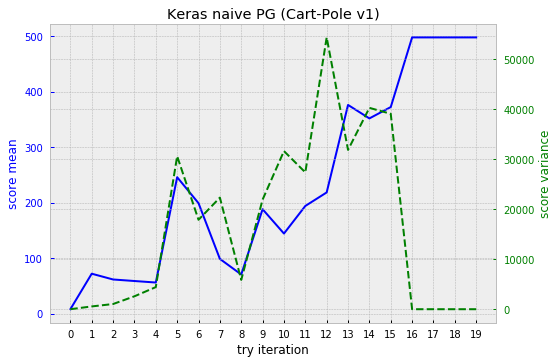

In [36]:
import seaborn
plt.style.use('bmh')
arr = np.asarray(record)
print arr.shape
fig, ax1 = plt.subplots()
t=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(t,arr[:,0], 'b-')
ax1.set_xlabel('try iteration')
ax1.set_xticks(t)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(t,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('Keras naive PG (Cart-Pole v1)');